## 1. Introduction

### Stock price influencers

Features that can be used for stock price predictions

Correlated assets:
an organization interacts with many external factods, including its competitors, clients, the global economy, the geopollitical situation, fiscal and monetary policies, access to capital and so on. Hence its stock price my be correlated nowith other assets suh as commodities, FX, borad based indices and fixed income scorities.

Technical indicators:
A lot of investors follow technical indicators. Moving average, exponential moving average and momentum.

Fundamental analysis:
Annual and querterly reports o fcompanices can be used to extract or determine key metrics such as Return on equity (ROE) and Price to Earnings (P/E)

News can indicate upcoming events that can potentially move the stock price in a certain direction

### Problem definition

SMA is good at confirming a momentum change but not at predicting one.



## Loading data

- Current data is loaded from yahoo finance and selects the Amundi MSCI World ETF from June 2009 to today.
- The baseline features include:
    - Open
    - High
    - Low
    - Close
    - Volume

In [120]:
import yfinance as yf
import pytz
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
from scipy.signal import argrelextrema

In [121]:
def dataset_loader(stock_name):
    dataset = yf.download(stock_name)

    start_date = str(dataset.index[0]).split()[0]
    end_date = str(dataset.index[1]).split()[0]

    # close = dataset["Close"]
    return dataset
    

In [122]:
df = dataset_loader('CW8.PA')

[*********************100%***********************]  1 of 1 completed


In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3469 entries, 2009-06-16 to 2023-01-03
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3469 non-null   float64
 1   High       3469 non-null   float64
 2   Low        3469 non-null   float64
 3   Close      3469 non-null   float64
 4   Adj Close  3469 non-null   float64
 5   Volume     3469 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 189.7 KB


## Cleaning Data

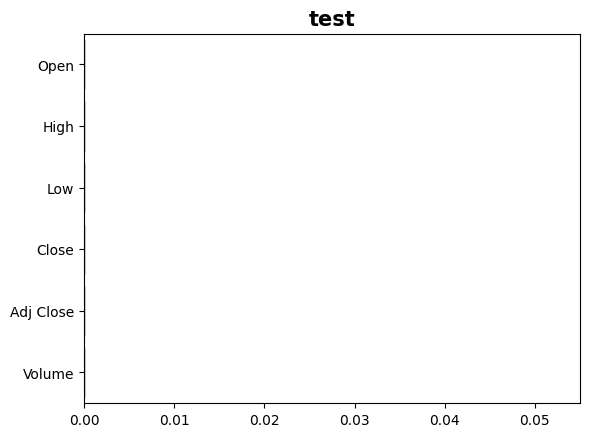

In [124]:
NaN_values = (df.isnull().sum()/len(df)*100).sort_values(ascending=False)

cmap = sns.color_palette("plasma")
fig, ax = plt.subplots()
sns.barplot(x = NaN_values, y=NaN_values.index, edgecolor="black", palette=cmap, ax=ax)

plt.title("test", size = 15, fontweight = "bold")
ax.set_xlim(0,None)
plt.show()


In [125]:
df[df.isna().any(axis=1)]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


## Data Exploration

In [126]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3469.000000,3469.000000,3469.000000,3469.000000,3469.000000,3469.000000
mean,221.801246,222.366898,221.177506,221.795647,221.795647,2331.003747
std,95.646258,96.352839,94.876416,95.634660,95.634660,7171.759036
min,80.330002,80.330002,80.330002,80.330002,80.330002,0.000000
25%,131.690002,131.690002,131.690002,131.690002,131.690002,0.000000
50%,214.409302,214.409302,214.409302,214.409302,214.409302,0.000000
75%,280.089996,282.084686,278.950012,280.305603,280.305603,2049.000000
max,439.119995,440.440002,436.500000,437.956604,437.956604,95151.000000


## Generating target variable

To define the target variable, we will use the golden cross:
>A golden cross is a chart pattern in which a relatively short-term moving average crosses above a long-term moving average. The golden cross is a bullish breakout pattern formed from a crossover involving a security's short-term moving average (such as the 15-day moving average) breaking above its long-term moving average (such as the 50-day moving average) or resistance level. As long-term indicators carry more weight, the golden cross indicates a bull market on the horizon and is reinforced by high trading volumes.

[Golden Cross reference](https://www.investopedia.com/terms/g/goldencross.asp)

- According to the golden cross rule, the signal (target) will be defined from moving averages windows
- If the short term window > long term window, then the signal becomes 1

Which goal to chose as a target:
- 50 days SMA Is the most popular variaety of the SMA and is used as a key level for stock and index chart. It i soften used with short-period EMA such as the 10-Day to confirm pricing positions. Breakouts can be signaled when 10 days EMA moves upward the 50-day SMA. In long positions, the 5-Day SMA can signal entry/exit point to ensure maximum profits

- 100 days SMA is often used to signal dip-buying opportunities. This signal cab be combined with others such as Bolliner Bands to offer greater support. for instance, when crossing th elower bands 20 band o fth eBollinger Bands the SMA-100 can indicate a long term reversal and the beginning of a bullish trend

- 200 Day SMA is a long temr trendline interpreted as the last indicator of key support for bullish trends 

In [127]:
def create_golden_cross_ref_target(df, sma1, sma2, tr_id=False):
    # Short moving average
    df['SMA'+str(sma1)] = df['Close'].rolling(sma1).mean() 

    # Long moving average
    df['SMA'+str(sma2)] = df['Close'].rolling(sma2).mean()

    # Generate the target
    df['signal'] = np.where(df['SMA'+str(sma1)] > df['SMA'+str(sma2)], 1, 0)
    display(df['signal'].value_counts())


def create_sell_buy_anticipation_target(df, n, tau):
    df['min'] = df.iloc[argrelextrema(df.Close.values, np.less_equal,
                        order=n)[0]]['Close']
    df['max'] = df.iloc[argrelextrema(df.Close.values, np.greater_equal,
                        order=n)[0]]['Close']

    df['action'] = np.where(df['max'].notna(), "sell", np.where(df['min'].notna(), "buy", None))
    df['action'].fillna(method='ffill', inplace=True)

    # for i in range(1, z):
    #     df.loc[df['sell'].shift(-i)==1, 'sell'] = 1 
    #     df.loc[df['buy'].shift(i)==1, 'buy'] = 1 


    df['signal'] = np.where(df['action'].shift(-tau) == "buy", 1, 0) # Shift the target by the anticipation factor
    display(df['signal'].value_counts())



# create_golden_cross_ref_target(df, 15, 50)
create_sell_buy_anticipation_target(df, 10, 0)


1    2177
0    1292
Name: signal, dtype: int64

## Time series visualization

In [128]:

df_viz = df.loc["2021-01-01":"2022-12-31"]

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=df_viz.index, y=df_viz["Close"],mode='lines',name="Close",line=dict(width=2.0)))
fig.add_trace(go.Scatter(x=df_viz.index, y=df_viz["min"],mode='markers',name="min",marker_color='green'))
fig.add_trace(go.Scatter(x=df_viz.index, y=df_viz["max"],mode='markers',name="max",marker_color='red'))
fig.add_trace(go.Scatter(x=df_viz.index, y=df_viz["signal"],mode='lines',name="signal",line=dict(width=2.0)),secondary_y="signal")


fig.update_layout(height=500,width=1100,template='plotly_white',title="test", margin=dict(l=50,r=80,t=50,b=40))
fig.show()

## Linear correlations

Text(0.5, 1.0, 'Feature Correlation to signal')

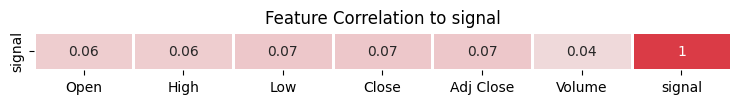

In [129]:
df.drop(columns=['min', 'max', 'action'], inplace=True)
corr_mat = df.corr().round(2).transpose()
shape = corr_mat.shape[0]
corr = corr_mat.loc[:, df.columns == "signal"].transpose()

f, ax = plt.subplots(figsize=(9,0.5))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, vmin=-0.3, vmax=0.3, center=0, cmap=cmap, square=False, lw=2, annot=True, cbar=False)
plt.title(f'Feature Correlation to signal')

The correlation between baseline variables and the target are minimal

This suggests:
- high nonlinearity
- stable osciliations relative to stationnary values
- Feature cannot model the target

## Freature engineering

Adding new technical indicators
- Moving average
Smooth the price fluctuation to get the general idea of where the trend is going
- [exponential moving average]("https://www.investopedia.com/terms/e/ema.asp")
> Exponential moving average (EMA) is a type of weighted moving average that give more weight to recent price data.
Removes the lag from the simple moving average
Recent data is more relevant and react quickly 
- [Price momentum oscilliator]("https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/momentum-oscillator#:~:text=The%20Momentum%20Oscillator%20measures%20the,indicator%20that%20oscillates%20around%20100.")

>The Price Momentum Oscillator oscillate around 0 (zero) center line and positive PMO reading would be an indication of a bullish rend, while negative PMO reading would indicate bearish trend. Based on this, one of the way to use the Price Momentum oscillator would be generate Buy and Sell signals on the crossovers of the PMO and zero center line: consider buying when PMO crosses above zero-line and consider selling when PMO crosses below zero-line.

- [Rate of Change]("https://www.investopedia.com/terms/r/rateofchange.asp")

- [Relative Strenght index]("https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/RSI#:~:text=Description,and%20oversold%20when%20below%2030.")

> The Relative Strength Index (RSI) is a momentum indicator that describes the current price relative to average high and low prices over a previous trading period. This indicator estimates overbought or oversold status and helps spot trend reversals, price pullbacks, and the emergence of bullish or bearish markets.

- [stochasti osciliators]("https://www.investopedia.com/terms/s/stochasticoscillator.asp")


In [130]:
# Calculate the moving averages
def ma(df, n):
    return pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n)) 

# Calculate exponential moving average
# Places greater signigicance on the most recent data points
def ema(df, n):
    return pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA' + str(n))

# Calculation of price momentum
def mom(df, n):
    return pd.Series(df.diff(n), name='Momentum' + str(n))

# Rate of change
def roc(df, n):
    M = df.diff(n-1)
    N = df.shift(n-1)
    return pd.Series((M/N)*100, name='ROC_'+ str(n))

# Relative Strenght index
def rsi(df, periods, ema=True) -> pd.Series:
    """ Returns a pd.Series with the relative strenght index"""

    # Create two series, one for the lower closes and one for the high closes
    df_delta = df['Close'].diff()
    down = -1 * df_delta.clip(upper=0) # Change the negative values to positive sign
    up = df_delta.clip(lower=0)

    # Use exponential moving average 
    ma_up = up.ewm(com=periods-1, adjust=True, min_periods=periods).mean()
    ma_down = down.ewm(com=periods-1, adjust=True, min_periods=periods).mean()
    rs = ma_up/ma_down
    rsi = 100 - (100/(1+rs))

    return rsi

# stochastic oscillators slow & fast
def sto(close, low, high, n,id): 
    stok = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    if(id == 0):
        return stok
    else:
        return stok.rolling(3).mean()

In [131]:
def tech_indi(df,tr_id=True):

    ''' Moving Average '''
    df['MA21'] = ma(df,10)
    df['MA63'] = ma(df, 30)
    df['MA252'] = ma(df, 200)
    lst_MA = ['MA21','MA63','MA252']

    ''' Exponentially Weighted Moving Average '''
    df['EMA10'] = ema(df, 10)
    df['EMA30'] = ema(df, 30)
    df['EMA200'] = ema(df, 200)
    lst_EMA = ['EMA10','EMA30','EMA200']

    ''' Momentum '''
    df['MOM10'] = mom(df['Close'], 10)
    df['MOM30'] = mom(df['Close'], 30)
    lst_MOM = ['MOM10','MOM30']

    ''' Relative Strength Index '''
    df['RSI10'] = rsi(df, 10)
    df['RSI30'] = rsi(df, 30)
    df['RSI200'] = rsi(df, 200)
    lst_RSI = ['RSI10','RSI30','RSI200']

    ''' Slow Stochastic Oscillators '''
    df['%K10'] = sto(df['Close'], df['Low'], df['High'],5,0)
    df['%K30'] = sto(df['Close'], df['Low'], df['High'],10,0)
    df['%K200'] = sto(df['Close'], df['Low'], df['High'], 20,0)
    lst_pK = ['%K10','%K30','%K200']

    ''' Fast Stochastic Oscillators '''
    df['%D10'] = sto(df['Close'], df['Low'], df['High'], 10,1)
    df['%D30'] = sto(df['Close'], df['Low'], df['High'], 30,1)
    df['%D200'] = sto(df['Close'], df['Low'], df['High'], 200,1)
    lst_pD = ['%D10','%D30','%D200']
    


In [132]:
tech_indi(df) # add technical features to training set

Text(0.5, 1.0, 'Feature Correlation to signal')

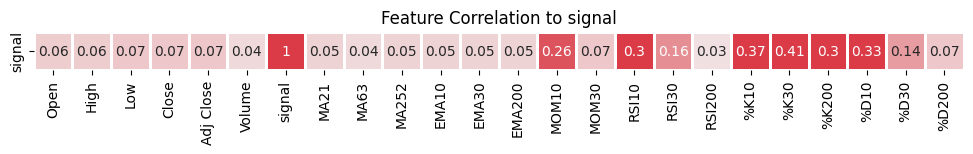

In [133]:
corr_mat = df.corr().round(2).transpose()
shape = corr_mat.shape[0]
corr = corr_mat.loc[:, df.columns == "signal"].transpose()

f, ax = plt.subplots(figsize=(12,0.5))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, vmin=-0.3, vmax=0.3, center=0, cmap=cmap, square=False, lw=2, annot=True, cbar=False)
plt.title(f'Feature Correlation to signal')

## Model Generation

In [238]:
from sklearn.model_selection import train_test_split
from xgboost import plot_importance, XGBClassifier, XGBRegressor, cv, DMatrix, plot_importance
from sklearn.model_selection import cross_val_score, KFold
from sklearn import metrics

# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

### Remove missing data

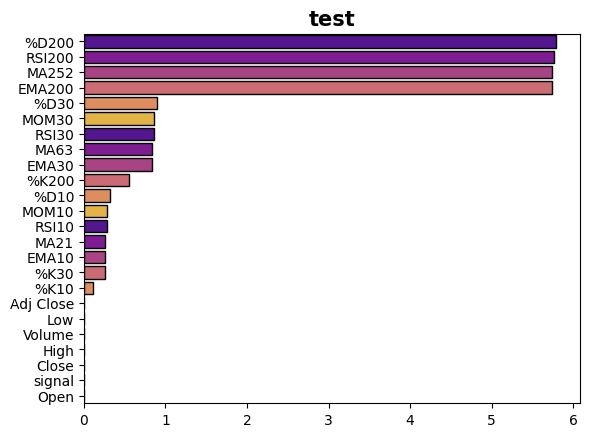

In [135]:
NaN_values = (df.isnull().sum()/len(df)*100).sort_values(ascending=False)

cmap = sns.color_palette("plasma")
fig, ax = plt.subplots()
sns.barplot(x = NaN_values, y=NaN_values.index, edgecolor="black", palette=cmap, ax=ax)

plt.title("test", size = 15, fontweight = "bold")
ax.set_xlim(0,None)
plt.show()

In [136]:
df.dropna(inplace=True)

### Split test and train sets

In [137]:
# We split the data into train and evaluation part
train_df,eval_df = train_test_split(df,test_size=0.2,shuffle=False)

In [219]:
# We split the target and the fetures
target = "signal"
y_train = train_df[target]
X_train = train_df.loc[:, train_df.columns != target]

y_eval = eval_df[target]
X_eval = eval_df.loc[:, eval_df.columns != target]

y_tot = pd.concat([y_train, y_eval])
X_tot = pd.concat([X_train, X_eval])



### XGBoost

In [220]:
# Définition du modèle
data_dmatrix = DMatrix(data=X_train,label=y_train)

params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

xgb_cv = cv(
    dtrain=data_dmatrix,
    nfold=3,
    params=params,
    num_boost_round=50,
    early_stopping_rounds=10,
    metrics='auc',
    as_pandas=True,
    seed=123
    )

xgb_cv.tail()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
45,0.897345,0.006047,0.829502,0.010824
46,0.899708,0.005099,0.831282,0.009620
47,0.900323,0.005122,0.831640,0.009253
48,0.900413,0.005110,0.832045,0.009565
49,0.901501,0.004466,0.832799,0.009313


In [ ]:
# declare parameters
space={
    'max_depth': hp.quniform("max_depth", 3, 18, 1),
    'gamma': hp.uniform ('gamma', 1,9),
    'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
    'reg_lambda' : hp.uniform('reg_lambda', 0,1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
    'n_estimators': 180,
    'seed': 0
    }
        
def objective(space):
    # instantiate the classifier 
    xgb_clf = XGBClassifier(
        n_estimators =space['n_estimators'], 
        max_depth = int(space['max_depth']), 
        gamma = space['gamma'],
        reg_alpha = int(space['reg_alpha']),
        min_child_weight=int(space['min_child_weight']),
        colsample_bytree=int(space['colsample_bytree'],
        eval_metric="auc",
        arly_stopping_rounds=10
        )

    evaluation = [( X_train, y_train), ( X_eval, y_eval)]

    # fit the classifier to the training data
    xgb_clf.fit(X_train, y_train,
            eval_set=evaluation,verbose=False)
    y_pred = xgb_clf.predict(X_test)
    roc_auc_score(y_test,y_pred)

Bayesian hyperparameter optimization using HYPEROPT

Hyperparameter optimization consists in four parts:
- initialize the domain space:
input values over which we want to search

- Define objective function
Any function which return a real value that we want to minimize

- Optimization algorithm
Methode used to construct the surrogate objective function and chose the next value to evaluate

- Results
Score or value pairs that the algorithm uses to build the model

\AUC 0.9227352010028612 for 199 rounds


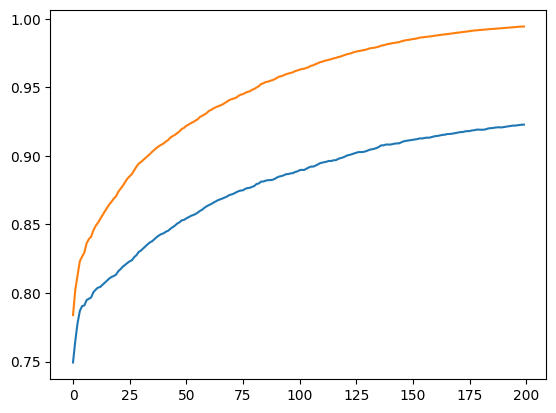

In [264]:
# declare parameters
params={
    'max_depth': 4,
    'learning_rate': 0.1,
    'objective': 'binary:logistic',
    # 'n_estimators': 200,
    'seed': 0
    }

train_params = {
    'eval_metric': ["error", "auc", "map"]
}
        

data_matrix = DMatrix(data=X_tot ,label=y_tot)

# instantiate the classifier 
xgb_cv = cv(
    dtrain= data_matrix,
    num_boost_round=200,
    early_stopping_rounds=10,
    metrics="auc",
    nfold=5,
    params=params
    )
# evaluation = [( X_train, y_train), ( X_eval, y_eval)]
# model.fit(X_train, y_train, eval_set=evaluation, early_stopping_rounds=10, **train_params, verbose=False, )

# train_history = model.evals_result()
# plt.plot(train_history["validation_0"]["auc"], label="training data")
# plt.plot(train_history["validation_1"]["auc"], label="test data")

max_auc = xgb_cv['test-auc-mean'].max()
boost_rounds = xgb_cv['test-auc-mean'].argmax()
print("\AUC {} for {} rounds".format(max_auc, boost_rounds))

plt.plot(xgb_cv["test-auc-mean"], label="test data")
plt.plot(xgb_cv["train-auc-mean"], label="train data")

xgb_clf = XGBClassifier(dtrain=data_matrix, params=params, num_boost_round=50, early_stopping_rounds=10, metrics="auc")


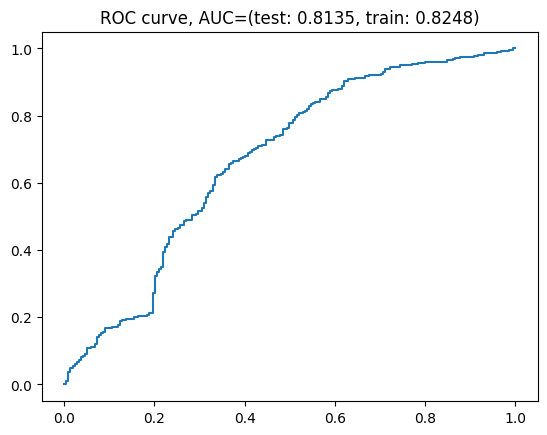

In [265]:
params={
    'max_depth': 4,
    'learning_rate': 0.1,
    'objective': 'binary:logistic',
    'n_estimators': 200,
    'seed': 0
    }

xgb_clf = XGBClassifier(**params)
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict_proba(X_eval)
fpr_test, tpr_test, _ = metrics.roc_curve(y_eval, y_pred[:, 1])
plt.title(f"ROC curve, AUC=(test: {auc_test:.4f}, train: {auc_train:.4f})")
plt.plot(fpr_test, tpr_test, label="test data")

## Model explicability

In [303]:
y = pd.Series([row[1] for row in y_pred], name="y")

df_viz_pred = pd.concat([X_eval.reset_index(), y_eval.reset_index(), y], axis=1)

In [304]:
df_viz_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 654 entries, 0 to 653
Data columns (total 27 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       654 non-null    datetime64[ns]
 1   Open       654 non-null    float64       
 2   High       654 non-null    float64       
 3   Low        654 non-null    float64       
 4   Close      654 non-null    float64       
 5   Adj Close  654 non-null    float64       
 6   Volume     654 non-null    int64         
 7   MA21       654 non-null    float64       
 8   MA63       654 non-null    float64       
 9   MA252      654 non-null    float64       
 10  EMA10      654 non-null    float64       
 11  EMA30      654 non-null    float64       
 12  EMA200     654 non-null    float64       
 13  MOM10      654 non-null    float64       
 14  MOM30      654 non-null    float64       
 15  RSI10      654 non-null    float64       
 16  RSI30      654 non-null    float64       
 1

In [298]:

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=df_viz_pred["Date"], y=df_viz_pred["Close"],mode='lines',name="Close",line=dict(width=2.0)))

fig.add_trace(go.Scatter(x=df_viz_pred["Date"], y=df_viz_pred["signal"],mode='lines',name="signal",line=dict(width=2.0)),secondary_y="signal")
fig.add_trace(go.Scatter(x=df_viz_pred["Date"], y=df_viz_pred["y"],mode='lines',name="pred",line=dict(width=2.0)), secondary_y="signal")


fig.update_layout(height=500,width=1100,template='plotly_white',title="test", margin=dict(l=50,r=80,t=50,b=40))
fig.show()

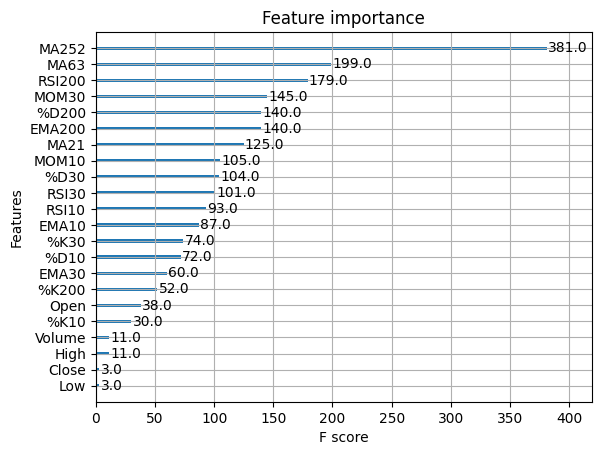

<Figure size 1600x1200 with 0 Axes>

In [266]:
plot_importance(xgb_clf)
plt.figure(figsize = (16, 12))
plt.show()

## WIP

### LDA

In [169]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, KFold


# Définition du modèle
model = LinearDiscriminantAnalysis()

# Définition de l'objet de validation croisée
cv = KFold(n_splits=5, shuffle=True ,random_state=10)

# Calcul des scores de validation croisée
scores = cross_val_score(model, X_train, y_train, cv=cv)

# Affichage des scores
print("Scores :", scores)
print("Moyenne des scores :", scores.mean())

Scores : [0.84886128 0.86542443 0.85714286 0.87784679 0.86514523]
Moyenne des scores : 0.8628841181069216


In [140]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=25, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

### RL

In [147]:
import tensorflow as tf
import numpy as np


In [191]:
input_dim = X_train.shape[1]
output_dim = 1

hidden_units = [128, 64, 32]

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(hidden_units[0], input_dim=input_dim, activation='relu'))
model.add(tf.keras.layers.Dense(hidden_units[1], activation='relu'))
model.add(tf.keras.layers.Dense(hidden_units[2], activation='relu'))
model.add(tf.keras.layers.Dense(output_dim, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy')

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
82/82 [==============================] - 2s 6ms/step - loss: 12.8906 - val_loss: 9.9887
Epoch 2/100
82/82 [==============================] - 0s 3ms/step - loss: 9.2236 - val_loss: 25.4259
Epoch 3/100
82/82 [==============================] - 0s 4ms/step - loss: 14.5046 - val_loss: 26.0004
Epoch 4/100
82/82 [==============================] - 0s 4ms/step - loss: 7.5682 - val_loss: 95.1298
Epoch 5/100
82/82 [==============================] - 0s 4ms/step - loss: 6.3921 - val_loss: 7.1962
Epoch 6/100
82/82 [==============================] - 0s 4ms/step - loss: 4.1386 - val_loss: 35.4948
Epoch 7/100
82/82 [==============================] - 0s 3ms/step - loss: 4.3074 - val_loss: 20.9328
Epoch 8/100
82/82 [==============================] - 0s 4ms/step - loss: 5.1513 - val_loss: 52.3045
Epoch 9/100
82/82 [==============================] - 0s 3ms/step - loss: 6.9785 - val_loss: 4.9382
Epoch 10/100
82/82 [==============================] - 0s 4ms/step - loss: 2.8475 - val_loss: 3.0637
E

In [192]:
predictions = model.predict(X_train)

82/82 [==============================] - 0s 2ms/step


In [193]:
df["pred"] =  pd.Series(predictions.flatten())

In [194]:
df_viz = df.loc["2021-01-01":"2022-12-31"]

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=df_viz.index, y=df_viz["Close"],mode='lines',name="Close",line=dict(width=2.0)))

fig.add_trace(go.Scatter(x=df_viz.index, y=df_viz["signal"],mode='lines',name="signal",line=dict(width=2.0)),secondary_y="signal")
fig.add_trace(go.Scatter(x=df_viz.index, y=y,mode='lines',name="pred",line=dict(width=2.0)), secondary_y="signal")


fig.update_layout(height=500,width=1100,template='plotly_white',title="test", margin=dict(l=50,r=80,t=50,b=40))
fig.show()